# 第四章　Monte Carlo法：估算体积和计数

作者：[王何宇](http://person.zju.edu.cn/wangheyu)

[浙江大学数学科学学院](http://www.math.zju.edu.cn)

本文档配合讲义第四章。讲义中的代码和图形都可在此验证。

In [1]:
from __future__ import print_function, division

# 这句话是非标准的python，用于ipthon或jupyter这样的系统中，表示绘图即刻自动展开。
%matplotlib inline

# 这里把全部Warning过滤掉了. 
# 参见https://docs.python.org/2/library/warnings.html
import warnings
warnings.filterwarnings('ignore')
from scipy.special import comb, perm
from scipy import stats
import numpy as np
import sys
import matplotlib.pyplot as plt
np.random.seed(250)

## 体积
下面是一个$m = 2$的单位正方形和均匀格点。

In [2]:
def mesh_generator(k):
    zi = range(k)
    for z1 in zi:
        for z2 in zi:
            xi = (z1 + 1/2)/k
            yi = (z2 + 1/2)/k
            plt.scatter(xi, yi, color='b',marker='.', s=5)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    axs = plt.gca()
    axs.set_aspect('equal', 'box')
    return

产生一个$10 \times 10$的网格。

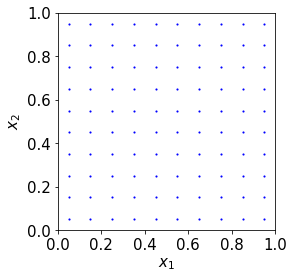

In [3]:
mesh_generator(10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'x',fontsize=15) 
plt.xlabel(r'$x_1$',fontsize=15)
plt.ylabel(r'$x_2$',fontsize=15)
plt.savefig(r'lattice.pdf')

还记得我们之前学过的一个对正态分布的反函数做有理逼近的算法么？

In [4]:
def inv_normal(y):
    c0 = 2.515517
    c1 = 0.802853
    c2 = 0.010328
    d1 = 1.432788
    d2 = 0.189269
    d3 = 0.001308
    t = np.sqrt(-np.log((min(y, 1 - y))**2))
    S1 = c0 + c1 * t + c2 * t**2
    S2 = 1 + d1 * t + d2 * t**2 + d3 * t**3
    S = t - S1 / S2
    w = y - 0.5
    if (w >= 0):
        F = S
    else:
        F = -S
    return F

我们用拟变换来生成一个正态分布采样看？

In [5]:
def sample_Normal(U):
    return [inv_normal(u) for u in U]

In [6]:
U = np.random.rand(1000000)
X = sample_Normal(U)

看一下采样效果。

Text(0.5,0,'Statistical Test of Standard Samples by Approximation Inverse Transform Method')

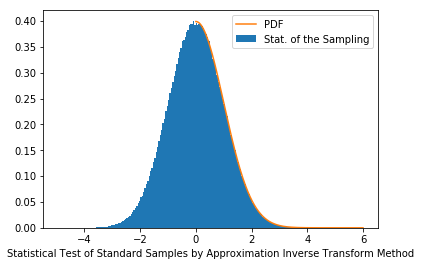

In [7]:
x = np.linspace(0,6,10000)
f = 1/np.sqrt(np.pi * 2) * np.exp(-x**2/2)
plt.hist(X, bins=200,normed=True, label="Stat. of the Sampling");
plt.plot(x, f, label=r"PDF")
plt.legend()
plt.xlabel(r"Statistical Test of Standard Samples by Approximation Inverse Transform Method")

似乎不错哦。然后我们再次回顾一下第一章的用于计算圆面积的程序。我们注意到它和MC算法其实是一致的。但是并没有给出统计检验部分。

In [8]:
def area_circle(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        x = dots[0, i] - 0.5
        y = dots[1, i] - 0.5
        if x * x + y * y < 0.25:
            inside += 1
    return inside / times

我们现在来验证我们的统计估计。

如果我们的$n = 10000$，那么我们的误差会是多少？根据Chebshev不等式，我们可以计算
$$
n_C = \frac{1}{4 \delta \varepsilon^2},
$$
我们令$\delta = 0.01$，也就是说绝对误差小于$\varepsilon$的概率要大于百分之99。此时，
$$
\varepsilon = \sqrt{\frac{1}{4 n_C \delta}} = \sqrt{\frac{1}{4 \times 10000 \times 0.01}} = \frac{1}{20} = 0.05.
$$
我们实际计算一下误差的分布：

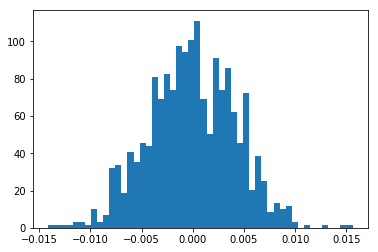

In [9]:
T = 1000  
n = 10000
abs_err = np.zeros(T)
for i in range(T):
    abs_err[i] = (area_circle(n) - np.pi / 4)
plt.hist(abs_err, bins=50, normed=True, label="Stat. of the Sampling");

远好于我们的估计，说明我们的估计太保守了。现在来看利用大数定理的估计：
$$
n_N = \left[\frac{\Phi^{-1}(1 - \frac{\delta}{2})}{2 \varepsilon}\right]^2,
$$
同样令$\delta = 0.01$，则
$$
\varepsilon = \frac{\Phi^{-1}(0.995)}{\sqrt{2 n_N}}.
$$
这个我们用上面的有理逼近帮一下，当然正常的方式是查表。

In [10]:
delta = 0.01
eps = inv_normal(1 - delta/2) / np.sqrt(2 * n)
print(eps)

0.018216740030314548


这个估计要好的多。

In [11]:
eps = np.sqrt(np.log(2/delta)/(2*n))
print(eps)

0.016276236307187292


这个已经很准了。反过来，如果我们希望偏差在0.01（百分之一）以内的概率大于0.999，也即$\delta = 0.001$，那么用最后一个估计来计算，则至少需要样本数为：

In [12]:
delta_fine = 0.001
eps = 0.01
2 * np.log(2 / delta_fine) / (4 * (eps)**2)

38004.51229771041

至少需要38005个样本点。

对于一些较难用数值方法计算的复杂的图形，比如：
$$
\int_0^1\sin(\frac{1}{x}) dx,
$$
用Monte Carlo法计算其曲线下面积（实际就是积分），毫无困难。我们甚至不需要对程序的算法部分做任何修改。先画一下我们要求面积的部分：

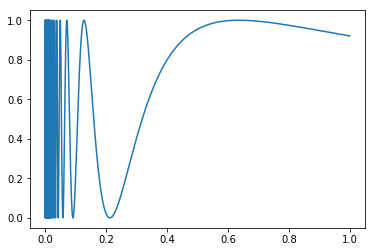

In [13]:
x = np.logspace(-100, 0, 100000)
plt.plot(x, 0.5 * np.sin(1/x) + 0.5)

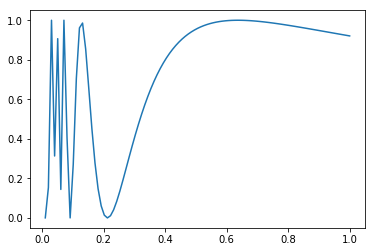

In [17]:
x = np.linspace(0, 1, 100)
plt.plot(x, 0.5 * np.sin(1/x) + 0.5)

除了目标函数不一样，其他部分和求圆面积完全一样。

In [18]:
def area_sin1_x(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        x = dots[0, i] - 0.5
        y = dots[1, i] - 0.5
        if y < 0.5 * np.sin(1/x) + 0.5:   # 只改了目标函数部分
            inside += 1
    return inside / times

先暴力一下给个参考解。

In [19]:
lambda_n = area_sin1_x(1000000)
print(lambda_n)

0.848843


连统计过程也一毛一样。可见MC方法对具体区域形状不敏感。这是它的另一个优势。

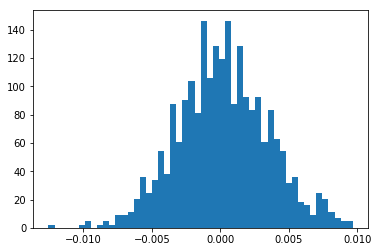

In [20]:
T = 1000
abs_err = np.zeros(T)
for i in range(T):
    abs_err[i] = (area_sin1_x(n) - lambda_n)
plt.hist(abs_err, bins=50, normed=True, label="Stat. of the Sampling");

下面来看一下讲义中最后一个样本数估计如何实现。这里我们需要求解一个最大值，而且根据理论结果，$w$函数是凹的，也就是我们只要求其导数的零点就行。而为了求导数零点，我们可以构建一个Newton迭代，于是还要再求2阶导数。这个函数尽管是初等函数，但求导过程不会很愉快，我们用Python的符号计算扩展包：Sympy来帮助我们。下面就是调用Sympy，声明e和u为符号，然后定义w，并对w求一次导。

In [23]:
import sympy as sym
e, u = sym.symbols('e,u', positive=True)
w = ((u + e) * sym.log(u/(u + e)) + (1 - u - e)* sym.log((1 - u)/(1 - u - e)))
sym.simplify(sym.diff(w, u))

(-e*u + e*(u - 1) + u*(u - 1)*(log(u/(e + u)) - log((u - 1)/(e + u - 1))))/(u*(u - 1))

再求其2阶导。

In [25]:
sym.simplify(sym.diff(w,u,2))

e*(-u**2*(e + u)*(u - 1) + u**2*(e + u)*(e + u - 1) + u*(u - 1)**2*(e + u - 1) - (e + u)*(u - 1)**2*(e + u - 1))/(u**2*(e + u)*(u - 1)**2*(e + u - 1))

注意我们已经调用了simplify函数，但大家注意到上面两个形式并不是最简。计算机对最简的理解和人类是不一样的。有节操的同学可以继续化简，不过这个只要等价对计算机也区别不大。但注意上面的形式都是符号计算，我们要转换成Python的函数以便于数值计算。复制粘帖下去，再把log改成np.log就行了。

In [26]:
def hoeffding_w(e, u):
    return ((u + e) * np.log(u/(u + e)) + (1 - u - e)* np.log((1 - u)/(1 - u - e)))

In [27]:
def hoeffding_dw(e, u):
    return ((-e*u + e*(u - 1) + u*(u - 1)*(np.log(u/(e + u)) - np.log((u - 1)/(e + u - 1))))/(u*(u - 1)))

In [28]:
def hoeffding_d2w(e, u):
    return (e*(-u**2*(e + u)*(u - 1) + u**2*(e + u)*(e + u - 1) + u*(u - 1)**2*(e + u - 1) - (e + u)*(u - 1)**2*(e + u - 1))/(u**2*(e + u)*(u - 1)**2*(e + u - 1)))

人肉Newton迭代了解一下：

In [29]:
eps=0.05
delta=0.01
u0=0.5
u1 = u0 - hoeffding_dw(eps,u0)/hoeffding_d2w(eps,u0)
err=np.abs(hoeffding_dw(eps,u1))
print(u1,err)

0.483400287311757 2.9848291220003233e-06


In [30]:
u0=u1
u1 = u0 - hoeffding_dw(eps,u0)/hoeffding_d2w(eps,u0)
err=np.abs(hoeffding_dw(eps,u1))
print(u1,err)

0.4833259153323706 3.2487948870663016e-13


In [31]:
u0=u1
u1 = u0 - hoeffding_dw(eps,u0)/hoeffding_d2w(eps,u0)
err=np.abs(hoeffding_dw(eps,u1))
print(u1,err)

0.4833259153242757 8.335943090326242e-17


根据理论结果，此时，$w$取到最大值：

In [32]:
print(hoeffding_w(eps,u1))

-0.0050027814879907845


对应的有，关于$\varepsilon = 0.05$，$\delta = 0.01$的样本数量估计：

In [33]:
n=-np.log(2/delta)/hoeffding_w(eps,u1)
print(n)

1059.0743128131196


我们再对比一下之前的$\delta = 0.001$和$\varepsilon = 0.01$的估计：

In [34]:
delta_fine = 0.001
eps = 0.01
u0=0.5
u1 = u0 - hoeffding_dw(eps,u0)/hoeffding_d2w(eps,u0)
err=np.abs(hoeffding_dw(eps,u1))
print(u1,err)

0.49666720009141285 9.484263502333254e-10


再次人肉Newton迭代（Newton迭代必须在几步内收敛）：

In [35]:
u0=u1
u1 = u0 - hoeffding_dw(eps,u0)/hoeffding_d2w(eps,u0)
err=np.abs(hoeffding_dw(eps,u1))
print(u1,err)

0.4966666074039795 8.327042788638943e-17


此时$w$最大值为：

In [36]:
print(hoeffding_w(eps,u1))

-0.0002000044446814845


样本数量估计为：

In [37]:
n=-np.log(2/0.001)/hoeffding_w(eps,u1)
print(n)

38003.66772671897


和之前的估计几乎一毛一样...（少了1）

接下去我们讨论区间估计。首先我们做一个实验，当$\lambda = 0.005$时，我们看一下实际上的模拟结果是如何分布的。为此我们还是调出之前编写的求圆面积的MC程序，反正MC方法对具体形状并不敏感。

In [21]:
def area_circle_small(times):
    inside = 0
    dots = np.random.rand(2, times)
    for i in range(times):
        x = dots[0, i] - 0.5
        y = dots[1, i] - 0.5
        if x * x + y * y < 0.005 / np.pi:
            inside += 1
    return inside

我们可以观察到频数$S$大大降低。这是正常的。

In [38]:
n = 1000
S = area_circle_small(1000)
V = S / n * (1 - S / n) / (n - 1)
print(S, V)

7 6.957957957957958e-06


如果我们做多次模拟并加以统计，我们能够得到实际频率的分布。

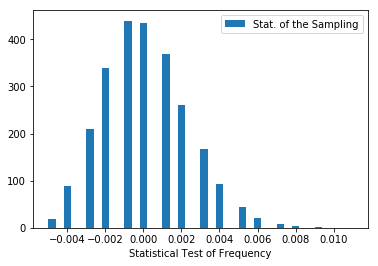

In [22]:
# 这个程序会很慢！
T = 50000  
n = 1000
abs_err = np.zeros(T)
for i in range(T):
    abs_err[i] = (area_circle_small(n) / n - 0.005)
plt.hist(abs_err, bins=40, normed=True, label="Stat. of the Sampling");
plt.legend()
plt.xlabel(r"Statistical Test of Frequency")
plt.savefig("bais_lambda_n.pdf")

上面的结果其实很好理解，因为$\lambda$本身就只有$0.005$，因此负方向最多只能再偏$0.005$，如果实际偏差会大于$\lambda$，那么在正方向和负方向就不会对称。事实上由于这种"边界"效应，除了$\lambda = 0.5$以外，置信区间都不会对称。

下面为了理解二项分布的累计分布函数，我们先从定义出发绘制，所以我们需要调用组合函数。

In [39]:
# 调这个包为了计算组合数
from scipy.special import comb

计算10000取4。精确计算组合数是一个指数时间算法，在实际计算机模拟中不能接受。这里只是作为教学演示。然后我们会讨论如何避免直接计算。

In [40]:
comb(10000,4)   

416416712497500.0

严格从定义出发构建二项分布的累积分布函数：

In [41]:
def binomial_CDF(n, mu, i):
    F = 0
    for j in range(i + 1):
        F += comb(n, j) * mu**j * (1 - mu)**(n - j)
    return F

我们可以绘制一下它关于参数$\mu$的变化情况：

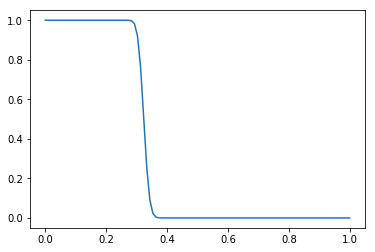

In [42]:
x = np.linspace(0, 1, 100)
plt.plot(x, binomial_CDF(1000, x, 323))

上面是关于参数$\mu$的变化，下面是固定$n = 100$，$\mu = 0.5$的累计分布函数：

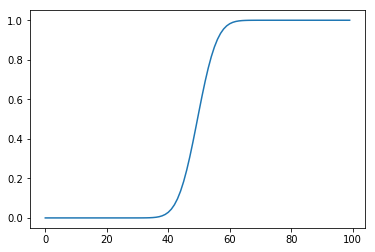

In [43]:
x = [i for i in range(100)]
y = [binomial_CDF(100, 0.5, i) for i in range(100)]
plt.plot(x, y)

为了计算二项分布的累计分布函数的逆变换，我们将其转化为不完全Beta函数来计算：

In [44]:
# 调用不完全Beta函数betainc和Beta函数
from scipy.special import betainc,beta

对比一下可以看到，不完全Beta函数可以替代二项分布累积分布函数。

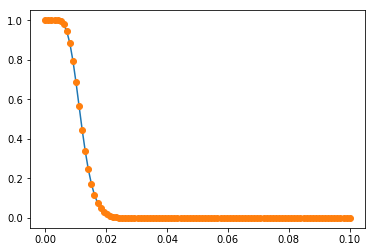

In [45]:
x = np.linspace(0, 0.1, 100)
plt.plot(x, 1-betainc(12, 1000-11+1, x))
plt.plot(x, binomial_CDF(1000, x, 11), 'o')
#plt.plot(x, (1-betainc(12,1000-12+1,x)-binomial_CDF(1000, x, 11)))

现在考虑如何求根，由于这个函数导数变化剧烈，但是单调，所以我们可以用二分法缩小含根区间。

In [46]:
def func(S, n, delta, z):
    return betainc(S, n - S + 1, z) - delta / 2

def bisection_root(S, n, delta, z1, z2, err, tol):
    while (True):
        f1 = func(S, n, delta, z1)
        if np.abs(f1) < tol:
            return z1
        z = (z1 + z2) * 0.5
        fz = func(S, n, delta, z)
        if np.abs(fz) < tol:
            return z
        if fz * f1 < 0:
            z2 = z
        else:
            z1 = z
        z = (z1 + z2) * 0.5
        if (np.abs(z1 - z2) < err):
            return z

缩小到误差范围$1 \times 10^{-3}$。

In [47]:
S = 11
n = 1000
delta = 0.01
z = bisection_root(S, n, delta, 0, 1, 1e-3, 1e-7)
print(z)

0.00439453125


然后启动一个Newton迭代。这里我们认真写一个Newton迭代吧。首先注意到不完全Beta函数是一个变上限积分，因此它的导数就是积分核，也就是二项分布的质量分布函数。

In [48]:
def dfunc(S, n, delta, z):
    return (z)**(S - 1)*(1 - z)**(n - S) / beta(S, n - S + 1)

In [49]:
def Newton(S, n, delta, theta, tol, MAX_IT):
    theta0 = theta
    err = np.abs(func(S, n, delta, theta0))
    k = 0
    while err > tol:
        theta1 = theta0 - func(S, n, delta, theta0) / dfunc(S, n, delta, theta0)
        theta0 = theta1
        err = np.abs(func(S, n, delta, theta0))
        k = k + 1
        if k > MAX_IT:
            print ("Disconvergence!")
            break
    return theta0

In [50]:
Newton(11, 1000, 0.01, 0.00439453125, 1e-15, 10)

0.0043336857667978365

下面我们对$S = 323$，$n = 1000$，$\delta = 0.01$利用上面的程序给出一个完整的区间估计。首先计算满足
$$
H_\theta(S, n - S + 1) = \frac{\delta}{2}
$$
的$\theta$：

In [51]:
S = 323
n = 1000
delta = 0.01
z = bisection_root(S, n, delta, 0, 1, 1e-3, 1e-7)
print(z)

0.28564453125


其实因为MC方法本身精度不会太高，这个估计就很好了，如果实在有必要，那么可以用Newton迭代继续加细：

In [52]:
z = Newton(S, n, delta, z, 1e-15, 10)
print(z)

0.2853347327850279


这是个神经病一样的估计。然后继续估计另一端，为此要重新定义一下func。

In [53]:
def func(S, n, delta, z):
    return betainc(S + 1, n - S, z) - 1 + delta / 2
def dfunc(S, n, delta, z):
    return (z)**S*(1 - z)**(n - S - 1) / beta(S + 1, n - S)

In [54]:
z = bisection_root(S, n, delta, 0, 1, 1e-3, 1e-7)
print(z)

0.36279296875


In [55]:
z = Newton(S, n, delta, z, 1e-15, 10)
print(z)

0.36237554840444247


其实只要把二分法的精度提高也行，比如误差界$5 \times 10^{-5}$足以保证有4位有效数字：

In [56]:
z = bisection_root(S, n, delta, 0, 1, 5e-5, 1e-7)
print(z)

0.3623809814453125
